In [1]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [3]:
import os

base_path = '/content/drive/MyDrive/MainDataset'
train_dir = os.path.join(base_path, 'Train')
val_dir = os.path.join(base_path, 'Validation')
test_dir = os.path.join(base_path, 'Test')

print("Train Folders:", os.listdir(train_dir))


Train Folders: ['black_sigatoka', 'potassium_deficiency', 'panama_disease', 'healthy', 'yellow_sigatoka']


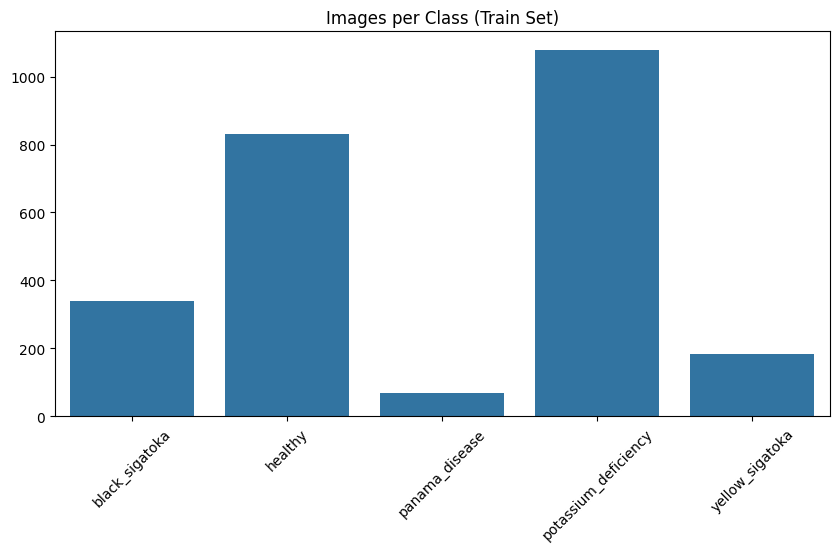

In [4]:
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns

data_dir = pathlib.Path(train_dir)
class_names = sorted([item.name for item in data_dir.glob("*/") if item.is_dir()])

class_counts = {cls: len(list(data_dir.glob(f"{cls}/*.jpg"))) for cls in class_names}

plt.figure(figsize=(10, 5))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.xticks(rotation=45)
plt.title("Images per Class (Train Set)")
plt.show()


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = 224
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(
    train_dir, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='categorical')

val_data = val_datagen.flow_from_directory(
    val_dir, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='categorical')

test_data = test_datagen.flow_from_directory(
    test_dir, target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)


Found 2504 images belonging to 5 classes.
Found 573 images belonging to 5 classes.
Found 539 images belonging to 5 classes.


In [6]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

def build_model(lr=0.0001, dropout=0.3):
    base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(dropout)(x)
    x = Dense(128, activation='relu')(x)
    output = Dense(len(class_names), activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_model()
model.summary()


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,169,349 (27.35 MB)

 Trainable params: 131,845 (515.02 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_densenet_model.h5", save_best_only=True)

history = model.fit(train_data, validation_data=val_data, epochs=10, callbacks=[early_stop, checkpoint])


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.5211 - loss: 1.2862

79/79 ━━━━━━━━━━━━━━━━━━━━ 781s 10s/step - accuracy: 0.5229 - loss: 1.2826 - val_accuracy: 0.5009 - val_loss: 1.3100
Epoch 2/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7927 - loss: 0.6308

79/79 ━━━━━━━━━━━━━━━━━━━━ 610s 8s/step - accuracy: 0.7928 - loss: 0.6305 - val_accuracy: 0.5567 - val_loss: 1.2432
Epoch 3/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8333 - loss: 0.4958

79/79 ━━━━━━━━━━━━━━━━━━━━ 652s 8s/step - accuracy: 0.8335 - loss: 0.4953 - val_accuracy: 0.5934 - val_loss: 1.1190
Epoch 4/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8458 - loss: 0.4158

79/79 ━━━━━━━━━━━━━━━━━━━━ 643s 8s/step - accuracy: 0.8461 - loss: 0.4153 - val_accuracy: 0.6056 - val_loss: 1.1035
Epoch 5/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8679 - loss: 0.3393

79/79 ━━━━━━━━━━━━━━━━━━━━ 611s 8s/step - accuracy: 0.8681 - loss: 0.3390 - val_accuracy: 0.6021 - val_loss: 1.0367
Epoch 6/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 600s 8s/step - accuracy: 0.8980 - loss: 0.2794 - val_accuracy: 0.6248 - val_loss: 1.1523
Epoch 7/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 638s 8s/step - accuracy: 0.9088 - loss: 0.2584 - val_accuracy: 0.6178 - val_loss: 1.2593
Epoch 8/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 599s 8s/step - accuracy: 0.9241 - loss: 0.2228 - val_accuracy: 0.6248 - val_loss: 1.1287
Epoch 9/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 626s 8s/step - accuracy: 0.9088 - loss: 0.2353 - val_accuracy: 0.6195 - val_loss: 1.1707
Epoch 10/10
79/79 ━━━━━━━━━━━━━━━━━━━━ 691s 8s/step - accuracy: 0.9200 - loss: 0.2290 - val_accuracy: 0.6283 - val_loss: 1.2437


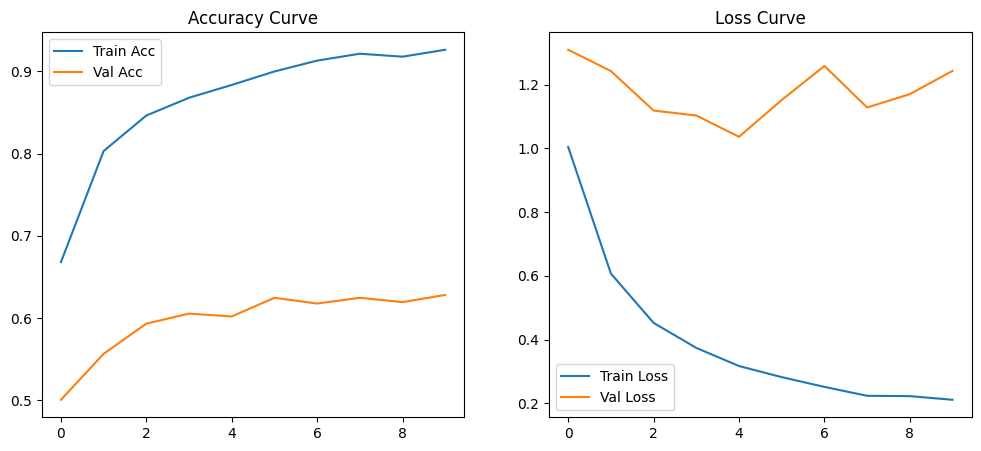

In [8]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Accuracy Curve")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss Curve")
plt.legend()
plt.show()


17/17 ━━━━━━━━━━━━━━━━━━━━ 169s 10s/step
                      precision    recall  f1-score   support

      black_sigatoka       0.37      0.23      0.29        73
             healthy       0.74      1.00      0.85       182
      panama_disease       1.00      0.47      0.64        15
potassium_deficiency       0.78      0.58      0.66       229
     yellow_sigatoka       0.50      0.88      0.64        40

            accuracy                           0.69       539
           macro avg       0.68      0.63      0.61       539
        weighted avg       0.70      0.69      0.67       539



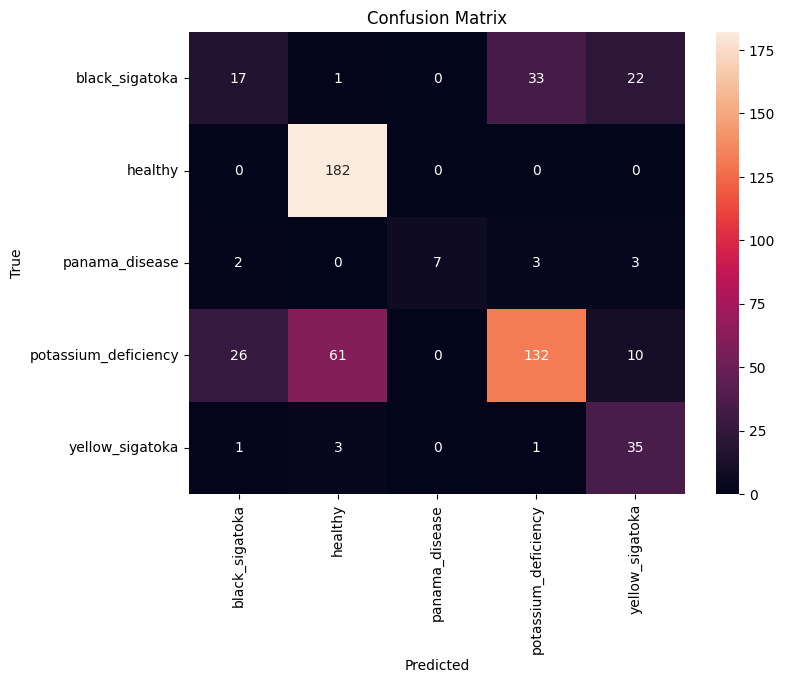

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns

preds = model.predict(test_data)
y_pred = np.argmax(preds, axis=1)
y_true = test_data.classes

print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


Saving PANAMA 0001 83 .jpg to PANAMA 0001 83 .jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
Predicted: panama_disease (47.85%)


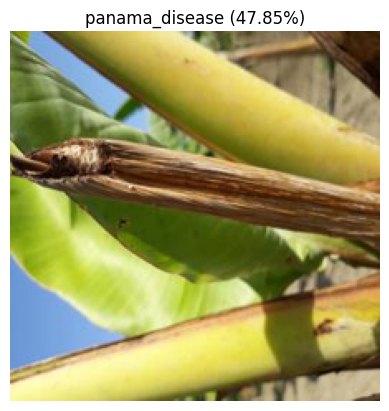

In [10]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from google.colab import files
import numpy as np
from PIL import Image

model = load_model("best_densenet_model.h5")

uploaded = files.upload()

for file_name in uploaded.keys():
    img = Image.open(file_name).resize((IMG_SIZE, IMG_SIZE))
    img_array = np.expand_dims(np.array(img)/255.0, axis=0)
    pred = model.predict(img_array)
    predicted_class = class_names[np.argmax(pred)]
    confidence = np.max(pred) * 100
    print(f"Predicted: {predicted_class} ({confidence:.2f}%)")
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{predicted_class} ({confidence:.2f}%)")
    plt.show()


Saving D 0001 209 .jpg to D 0001 209 .jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted: potassium_deficiency (75.68%)


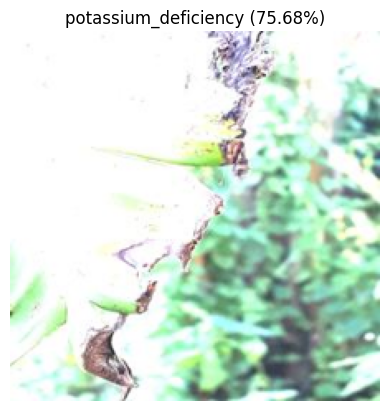

In [11]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from google.colab import files
import numpy as np
from PIL import Image

model = load_model("best_densenet_model.h5")

uploaded = files.upload()

for file_name in uploaded.keys():
    img = Image.open(file_name).resize((IMG_SIZE, IMG_SIZE))
    img_array = np.expand_dims(np.array(img)/255.0, axis=0)
    pred = model.predict(img_array)
    predicted_class = class_names[np.argmax(pred)]
    confidence = np.max(pred) * 100
    print(f"Predicted: {predicted_class} ({confidence:.2f}%)")
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{predicted_class} ({confidence:.2f}%)")
    plt.show()


Saving 20240204_092123.jpg to 20240204_092123.jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted: healthy (92.65%)


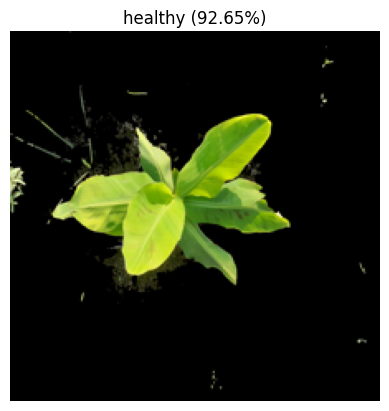

In [12]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from google.colab import files
import numpy as np
from PIL import Image

model = load_model("best_densenet_model.h5")

uploaded = files.upload()

for file_name in uploaded.keys():
    img = Image.open(file_name).resize((IMG_SIZE, IMG_SIZE))
    img_array = np.expand_dims(np.array(img)/255.0, axis=0)
    pred = model.predict(img_array)
    predicted_class = class_names[np.argmax(pred)]
    confidence = np.max(pred) * 100
    print(f"Predicted: {predicted_class} ({confidence:.2f}%)")
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{predicted_class} ({confidence:.2f}%)")
    plt.show()
